In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import tensorflow as tf
import os
from keras.backend import set_session
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider
from keras.models import Sequential, Model
import keras
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.utils import np_utils
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam
from keras import optimizers
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D,Input, Lambda, concatenate,Conv2DTranspose, UpSampling2D
from keras.datasets import mnist
from keras import backend as K

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


In [2]:
#啟用GPU跑程式
def create_session(gpu_id='0', pp_mem_frac=None):

    tf.reset_default_graph()
    os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id # can multiple?
    with tf.device('/gpu:' + gpu_id):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if pp_mem_frac is not None:
            config.gpu_options.per_process_gpu_memory_fraction=pp_mem_frac
        session = tf.Session(config = config)
    return session
gpu_id = '0'
sess = create_session(gpu_id)
set_session(sess)


# **<font size = 5>讀取資料</font>**

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

# **<font size = 5>參考助教的程式建立VAE</font>**

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)  
enc_log_var = Dense(2)  

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           78500       input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             202         dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             202         dense_1[0][0]                    
___________________________________________________________________________________________

# **<font size = 5>定義損失函數並載入權重</font>**

In [11]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [12]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

# **<font size = 5>設定encoder及decoder</font>**

In [14]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [15]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [16]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 5578 圖的 latent 表示為 [[-0.6359745  -0.28887382]]


# **<font size = 5>encoder視覺化</font>**

In [18]:
index = np.random.randint(x_test.shape[0], size=4000)
VAE_latent = VAE_Encoder.predict(x_test[index])

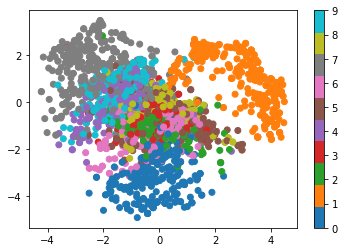

In [19]:
plt.scatter(VAE_latent[:,0], VAE_latent[:,1], c=y_test0[index], cmap='tab10')
plt.colorbar()

# **<font size = 5>decoder視覺化</font>**

In [21]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [22]:

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)

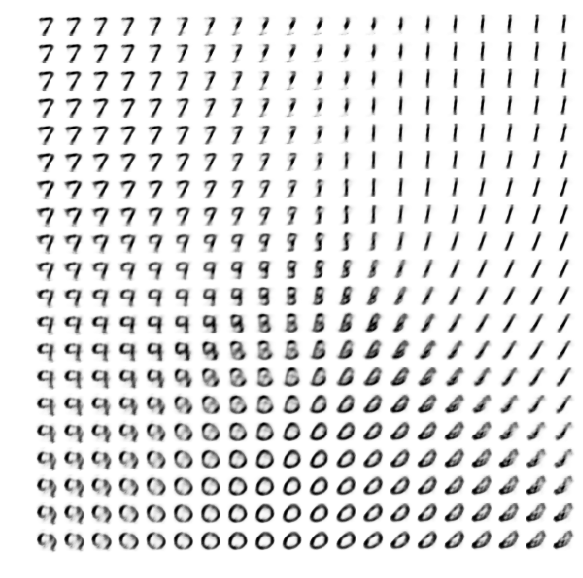

In [23]:
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# **<font size = 5>互動化，可讓使用者選index並動態變化</font>**

In [24]:
def inBetween(t, idx_1, idx_2):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [25]:
interact(inBetween, t = FloatSlider(value=0.5, min=0, max=1.0, step=0.01,),
        idx_1 = IntSlider(value = 30000, min = 0, max = 59999, step=1,),
        idx_2 = IntSlider(value = 33333, min=0, max=59999, step=1,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.01), IntSlider(value=30000, desc…

<function __main__.inBetween(t, idx_1, idx_2)>